In [375]:
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from keras.layers import Input, Dense, BatchNormalization, LSTM, Embedding, Bidirectional
from keras.models import Model

from sklearn.model_selection import train_test_split

from gensim.models.doc2vec import Doc2Vec, TaggedDocument, Word2Vec

from pprint import pprint

EPOCHS = 20


In [96]:
l_r_lookup = [
    {'source': 'Business Insider','label': .5},
    {'source': 'Talking Points Memo','label': .5}, 
    {'source': 'NPR', 'label': .5}, # https://www.allsides.com/news-source/npr-media-bias
    {'source': 'Reuters', 'label': .5}, # https://www.allsides.com/news-source/reuters
    {'source': 'New York Times', 'label': .2}, # https://www.allsides.com/news-source/new-york-times
    {'source': 'CNN','label': .2}, # https://www.allsides.com/news-source/cnn-media-bias
    {'source': 'Atlantic', 'label': .4}, # https://www.allsides.com/news-source/atlantic
    {'source': 'Guardian', 'label': .4}, # https://www.allsides.com/news-source/guardian
    {'source': 'Vox', 'label': .1}, # https://www.allsides.com/news-source/vox-news-media-bias
    {'source': 'Buzzfeed News','label': .3}, # https://www.allsides.com/news-source/buzzfeed-media-bias
    {'source': 'Washington Post','label': .4}, # https://www.allsides.com/news-source/washington-post-media-bias
    {'source': 'Fox News','label': .8}, # https://www.allsides.com/news-source/fox-news-media-bias
    {'source': 'National Review', 'label': .9}, # https://www.allsides.com/news-source/national-review
    {'source': 'Breitbart','label': .9}, # https://www.allsides.com/news-source/breitbart
    {'source': 'New York Post', 'label': .7} # https://www.allsides.com/news-source/new-york-post
]


In [97]:
data_loc = 'data/full_data.csv'

to_replace = [_s.get('source') for _s in l_r_lookup]
replace_with  = ['' for _s in l_r_lookup]

def get_full_data():
    """
    Concatenate the data that was downloaded from the kaggle zip file.
    
    If any of the content has the title of the source, remove that from
    the title so as to not bias the algorithm to those tokens.
    """
    try:
        df = pd.read_csv(data_loc)
        return df
    except Exception as err:
        pass
    
    data_dir = '/Users/john/Downloads/archive/'
    dfs = []
    for _f in os.listdir(data_dir):
        dfs.append(pd.read_csv(data_dir + _f))

    df = pd.concat(dfs)
    df['content'] = df.content.replace(to_replace, replace_with, regex=True)
    df['title'] = df.title.replace(to_replace, replace_with, regex=True)
    
    full_data.to_csv(data_loc)

    return df
    
full_data = get_full_data()

assert(len(full_data[full_data['title'].astype(str).str.contains('Fox News')]) == 0)
assert(len(full_data[full_data['title'].astype(str).str.contains('Breitbart')]) == 0)


In [98]:
def apply_labels_to_data(df):
    """
    Join the allnews data to the labels we hardcoded above assigning each text a linear scaled value.
    """
    left_r_lookup = pd.DataFrame(l_r_lookup)
    left_r_lookup
        
    training_df = df.merge(left_r_lookup, how='inner', left_on='publication', right_on='source')


    return training_df

labeled_df = apply_labels_to_data(full_data)
print(len(labeled_df))


130599
0
0


In [176]:
USE_HEADLINE = True
def get_train_data(df):
    
    if USE_HEADLINE:
        df = df[['title', 'label', 'source']]
        df.columns = [['content', 'label', 'source']]
        return df
    else:
        return df[['content', 'label', 'source']]
    
train_df = get_train_data(labeled_df)
train_df = train_df.sample(frac=1).reset_index(drop=True) # shuffle

In [453]:
class Algo:
    def __init__(self, df, vector_size=50, model_type='DNN', plot=False, lstm_units=10,\
                 stop_early=False, verbose=0, epochs=EPOCHS, dropout_pct=.2):
        self.df = df
        self.vector_size = vector_size
        self.model_type = model_type
        self.loss_fn = 'mean_absolute_error'       
        self.lstm_units = lstm_units
        self.plot = plot
        self.stop_early = stop_early
        self.experiment_name = '{0} - vec: {1}'.format(model_type, vector_size)
        self.dropout_pct = dropout_pct
        self.verbose=verbose
        self.epochs = 100

    def vectorize(self):
        pass # must override

    def get_model(self, input_len, data_shape):
        
        model = Sequential()
        

        if self.model_type == 'DNN':
            model.add(Input(shape=(input_len,)))
            model.add(Dense(inputlen, activation='relu'))
        elif self.model_type == 'LSTM':
            model.add(Embedding(input_len, self.lstm_units, mask_zero=True))
            model.add(Bidirectional(LSTM(self.lstm_units, dropout=self.dropout_pct, recurrent_dropout=self.dropout_pct)))
              
        else:
            raise Exception('Model Type not Recognized')
            
        model.add(Dense(outputlen, activation='sigmoid'))
        
        
        model.compile(optimizer='SGD', 
                           loss=self.loss_fn,
                           metrics=['accuracy'])


        # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1), loss=loss_fn) #  , metrics=['accuracy'])

        return model
    
    def train(self, train_vectors, train_labels):
        
        callbacks = [] 
        if self.stop_early:
            callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2))

        input_len = len(train_vectors[0])
        outputlen = 1
    
        model = self.get_model(input_len, train_vectors.shape)

        history = model.fit(train_vectors, 
                        train_labels, 
                        batch_size=8, 
                        epochs=self.epochs, 
                        verbose=self.verbose, 
                        validation_split=0.3, 
                        callbacks=callbacks)
        return model, history
    
    def evaluate(self, model, test_vectors, test_labels):
        res = model.evaluate(test_vectors, test_labels, verbose=self.verbose)
        return res

    def plot_loss(self, history):
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')

        lower = min(min(history.history['loss']),min(history.history['val_loss']))
        upper = max(max(history.history['loss']), max(history.history['val_loss']))

        plt.ylim([lower, upper])
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.legend()
        plt.grid(True)
        
    def main(self):
        
        start_time = datetime.datetime.now()
        v = self.vectorize()

        label_vecs = self.df['label']
        
        train_vectors, test_vectors, train_labels, test_labels = train_test_split(
              np.array(v), label_vecs, test_size=0.22)
        
        model, history = self.train(train_vectors, train_labels)
        test_loss, _ = self.evaluate(model, test_vectors, test_labels)
        
        predictions = self.predict(model, test_vectors, test_labels)
        
        train_loss = history.history['loss'][-1]
        validation_loss = history.history['val_loss'][-1]
        
        end_time = datetime.datetime.now()
        task_duration = (end_time-start_time).total_seconds()
        results = {
            'experiment_name': self.experiment_name,
            'task_duration': task_duration,
            'test_loss': test_loss,
            'train_loss': train_loss,
            'validation_loss': validation_loss,
            'epochs_completed': len(history.history['accuracy']),
            'epochs': EPOCHS,
            'stop_early': self.stop_early,
            'vector_size': self.vector_size,
            'dropout_pct': self.dropout_pct,
            'lstm_units': self.lstm_units,
            'model_type':self.model_type
        }
        if self.plot:
            self.plot_loss(history)
        
        return predictions, results, model
    
    def predict(self, model, test_vectors, test_labels):

        preds = model.predict(test_vectors).flatten()

        test_labels['predictions'] = preds
                
        final = self.df.merge(test_labels, left_index=True, right_index=True)
        return final
        

In [454]:
class Doc2VecAlgo(Algo):
    
    def vectorize(self):

        documents = []

        self.df['content'] = self.df['content'].astype(str)
        
        for ix in self.df.index:
            documents.append(TaggedDocument(self.df.iloc[ix]['content'].split(), [ix]))
        kw = {'vector_size': self.vector_size, 'window': 2, 'min_count':1, 'workers':4}
        model = Doc2Vec(documents, **kw)

        vectors = []
        for i, row in self.df.iterrows():
            if i % 10000 == 0 and self.verbose == 1:
                print('vectorize:', i)
            vectors.append(model.infer_vector(row.content.split()))

        return vectors

# a = Doc2VecAlgo(train_df, vector_size=50, model_type = 'LSTM')
# _, results = a.main()
# pprint(results)

In [382]:
from sklearn.feature_extraction.text import TfidfVectorizer

class TfidfAlgo(Algo):
    def vectorize(self):
        all_content = []
        for ix, row in self.df.iterrows():
            all_content.append(row.content)
        v = TfidfVectorizer(max_features=self.vector_size)
        vectorized = v.fit_transform(all_content)
        return vectorized.toarray()

a = TfidfAlgo(train_df, vector_size=50, model_type = 'DNN', plot=True)
v = a.vectorize()
_, results = a.main()

In [407]:
import time
import json
from itertools import product


params = {
    'vector_size': [20, 50, 100, 200],
    'lstm_units':[64, 32, 16, 8, 4, 2],
    'model': [TfidfAlgo, Doc2VecAlgo],
    'model_type': ['LSTM'],
    'verbose': [0]
}

lstm_permutations = [dict(zip(params, v)) for v in product(*params.values())]
params.pop('lstm_units')
params['model_type'] = ['DNN']
dnn_permutations = [dict(zip(params, v)) for v in product(*params.values())]

permutations = dnn_permutations + lstm_permutations

print('-- len permutations ---')
print('we have', len(permutations), 'permutations..', len(lstm_permutations),    'with lstm and', len(dnn_permutations), 'with dnn' )

results = []

for i, (p) in enumerate(permutations):
    model = p.pop('model')
    p['df'] = train_df
    _m = model(**p)
    _, model_results = _m.main()
    with open('out_stream.txt', 'a') as f:
        f.write(json.dumps(model_results) + '\n')
    results.append(model_results)

df = pd.DataFrame(results)

now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
df.to_csv('final-output/{ts}.csv'.format(ts=now))
display(df)

-- len permutations ---
we have 56 permutations.. 48 with lstm and 8 with dnn


# We Found ideal hyper parameters for our model below we'll analyze the results in more detail


vectorize: 0
vectorize: 10000
vectorize: 20000
vectorize: 30000
vectorize: 40000
vectorize: 50000
vectorize: 60000
vectorize: 70000
vectorize: 80000
vectorize: 90000
vectorize: 100000
vectorize: 110000
vectorize: 120000
vectorize: 130000
Epoch 1/100
8914/8914 [==============================] - 15s 2ms/step - loss: 0.2142 - accuracy: 0.0000e+00 - val_loss: 0.2123 - val_accuracy: 0.0000e+00
Epoch 2/100
8914/8914 [==============================] - 13s 1ms/step - loss: 0.2094 - accuracy: 0.0000e+00 - val_loss: 0.2078 - val_accuracy: 0.0000e+00
Epoch 3/100
8914/8914 [==============================] - 16s 2ms/step - loss: 0.2056 - accuracy: 0.0000e+00 - val_loss: 0.2044 - val_accuracy: 0.0000e+00
Epoch 4/100
8914/8914 [==============================] - 13s 1ms/step - loss: 0.2024 - accuracy: 0.0000e+00 - val_loss: 0.2014 - val_accuracy: 0.0000e+00
Epoch 5/100
8914/8914 [==============================] - 14s 2ms/step - loss: 0.1993 - accuracy: 0.0000e+00 - val_loss: 0.1984 - val_accuracy: 0.0

8914/8914 [==============================] - 21s 2ms/step - loss: 0.1759 - accuracy: 0.0000e+00 - val_loss: 0.1774 - val_accuracy: 0.0000e+00
Epoch 49/100
8914/8914 [==============================] - 20s 2ms/step - loss: 0.1757 - accuracy: 0.0000e+00 - val_loss: 0.1773 - val_accuracy: 0.0000e+00
Epoch 50/100
8914/8914 [==============================] - 17s 2ms/step - loss: 0.1756 - accuracy: 0.0000e+00 - val_loss: 0.1775 - val_accuracy: 0.0000e+00
Epoch 51/100
8914/8914 [==============================] - 15s 2ms/step - loss: 0.1755 - accuracy: 0.0000e+00 - val_loss: 0.1771 - val_accuracy: 0.0000e+00A: 
Epoch 52/100
8914/8914 [==============================] - 13s 1ms/step - loss: 0.1753 - accuracy: 0.0000e+00 - val_loss: 0.1769 - val_accuracy: 0.0000e+00
Epoch 53/100
8914/8914 [==============================] - 13s 1ms/step - loss: 0.1752 - accuracy: 0.0000e+00 - val_loss: 0.1768 - val_accuracy: 0.0000e+00
Epoch 54/100
8914/8914 [==============================] - 14s 2ms/step - loss: 0

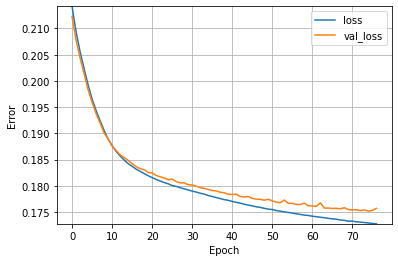

In [456]:
ideal_model_kw = {
    'df': train_df,
    'model_type': 'DNN',
    'vector_size': 100,
    'epochs':100,
    'stop_early':True,
    'verbose':1,
    'plot':True
}
a = Doc2VecAlgo(**ideal_model_kw)
predicted_df, results, trained_model = a.main()



array([[<AxesSubplot:title={'center':'Atlantic'}>,
        <AxesSubplot:title={'center':'Breitbart'}>,
        <AxesSubplot:title={'center':'Buzzfeed News'}>,
        <AxesSubplot:title={'center':'CNN'}>],
       [<AxesSubplot:title={'center':'Fox News'}>,
        <AxesSubplot:title={'center':'Guardian'}>,
        <AxesSubplot:title={'center':'NPR'}>,
        <AxesSubplot:title={'center':'National Review'}>],
       [<AxesSubplot:title={'center':'New York Post'}>,
        <AxesSubplot:title={'center':'New York Times'}>,
        <AxesSubplot:title={'center':'Reuters'}>,
        <AxesSubplot:title={'center':'Vox'}>],
       [<AxesSubplot:title={'center':'Washington Post'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

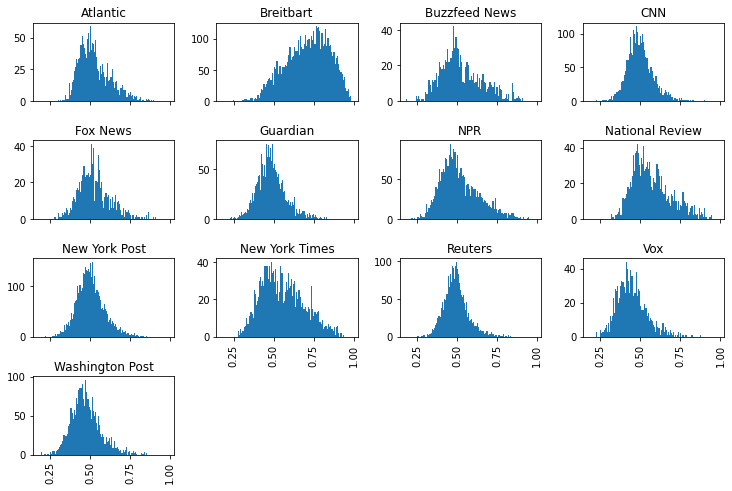

In [216]:
new_predicted_df.columns=['text', 'lab', 'src', 'lab_2', 'preds']
predict_df[['src', 'preds']].hist(by='src', bins=100, figsize=(12,8), sharex=True)